In [157]:
#import libraries to be used
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#import cleaned crash and weather data
crash = pd.read_csv('/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/Crashes_in_DC_cleaned.csv')
weather = pd.read_csv('/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/weatherData_Final.csv')

#looking at shape data to see how many rows and columns i should expect
#in the new data set. 128758 rows and 22 columns
crash_shape = crash.shape
weather_shape = weather.shape

print('the crash data has', crash_shape,'rows and columns')
print('the weather data has',weather_shape,'rows and columns')

the crash data has (106422, 6) rows and columns
the weather data has (1461, 16) rows and columns


In [158]:
#Removes timezone and strips the time of dat from the crash REPORTDATE
#column to prepared for the merge
crash['REPORTDATE'] = pd.to_datetime(crash['REPORTDATE'])
crash['REPORTDATE'] = crash['REPORTDATE'].dt.tz_convert(None)
crash['REPORTDATE'] = crash['REPORTDATE'].dt.strftime('%Y-%m-%d')
crash['REPORTDATE'] = pd.to_datetime(crash['REPORTDATE'])

#need to convert date time column in the weather DF so it can merge
weather['Date time'] = pd.to_datetime(weather['Date time'])


In [159]:
#merging the files on the date
merged = pd.merge(crash, weather, how = 'inner', 
                  left_on = crash['REPORTDATE'],
                  right_on = weather['Date time'])
print(merged.shape)
print(merged.columns)
print(merged.dtypes)

(106422, 23)
Index(['key_0', 'REPORTDATE', 'CrashCount', 'Hour', 'Day', 'Month', 'Year',
       'Date time', 'Maximum Temperature', 'Minimum Temperature',
       'Temperature', 'Wind Chill', 'Heat Index', 'Precipitation', 'Snow',
       'Snow Depth', 'Wind Speed', 'Wind Direction', 'Wind Gust', 'Visibility',
       'Cloud Cover', 'Relative Humidity', 'Conditions'],
      dtype='object')
key_0                  datetime64[ns]
REPORTDATE             datetime64[ns]
CrashCount                      int64
Hour                            int64
Day                             int64
Month                           int64
Year                            int64
Date time              datetime64[ns]
Maximum Temperature           float64
Minimum Temperature           float64
Temperature                   float64
Wind Chill                    float64
Heat Index                    float64
Precipitation                 float64
Snow                          float64
Snow Depth                    float64
Wi

In [160]:
#drop and rename columns
merged = merged.drop(columns = ['Date time', 'Maximum Temperature', 'Minimum Temperature', 'Wind Chill', 'Heat Index',
                               'Wind Speed', 'Wind Direction', 'Wind Gust', 'Cloud Cover','Relative Humidity', 'Temperature',
                                'Visibility', 'Conditions', 'Snow', 'Snow Depth', 'key_0'])
merged.columns

Index(['REPORTDATE', 'CrashCount', 'Hour', 'Day', 'Month', 'Year',
       'Precipitation'],
      dtype='object')

In [161]:
#Precipitaiton indicator
merged['Precipitation_indicator'] = np.where(merged['Precipitation'] != 0, 1, 0)

merged = merged.drop(columns = ['Precipitation'])


In [162]:
#grouping by date 
merged2 = merged.groupby(['Hour','Day', 'Month'], as_index=False).agg(
{
    'CrashCount':'sum',
    'Precipitation_indicator':'sum'
})
print(merged2.dtypes)
print(merged2.shape)
merged2

Hour                       int64
Day                        int64
Month                      int64
CrashCount                 int64
Precipitation_indicator    int64
dtype: object
(8756, 5)


,Hour,Day,Month,CrashCount,Precipitation_indicator
0,0,1,1,14,5
1,0,1,2,13,9
2,0,1,3,19,19
3,0,1,4,19,14
4,0,1,5,11,2
...,...,...,...,...,...
8751,23,31,5,24,12
8752,23,31,7,19,14
8753,23,31,8,16,1
8754,23,31,10,15,2


In [163]:
#adding weekday indicator then creating groupings based off weekend, ending/begning of the week, and middle of 
#the week

merged2['WEEKDAY'] = merged['REPORTDATE'].dt.dayofweek
dummy0 = pd.get_dummies(merged2['WEEKDAY'])
dummy0.columns = ['MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU']
merged2 = pd.concat([merged2, dummy0] , axis = 1)
merged2
#merged2 = merged2.drop(columns = ['Day'])


#dummies on hour
dummy = pd.get_dummies(merged2['Hour'])
dummy.columns = ['Hour_0','Hour_1','Hour_2','Hour_3','Hour_4','Hour_5','Hour_6','Hour_7','Hour_8','Hour_9',
                 'Hour_10','Hour_11','Hour_12','Hour_13','Hour_14','Hour_15','Hour_16','Hour_17','Hour_18',
                 'Hour_19','Hour_20','Hour_21','Hour_22','Hour_23']
merged2 = pd.concat([merged2, dummy] , axis = 1)


#real dummies on month
dummy3 = pd.get_dummies(merged2['Month'])
dummy3.columns = ['JAN', 'FEB','MAR', 'APR', 'MAY', 'JUN', 'JUL', 'AUG', 'SEP',
                 'OCT', 'NOV', 'DEC']              
merged2 = pd.concat([merged2, dummy3] , axis = 1)



#breaking hour into 4 periods
merged2['T_12to5AM'] = merged2['Hour'].apply(lambda x: 1 if x < 6 else 0)
merged2['T_6to11AM'] = merged2['Hour'].apply(lambda x: 1 if (x >= 6 and x < 12) else 0)
merged2['T_12to5PM'] = merged2['Hour'].apply(lambda x: 1 if (x >= 12 and x < 18) else 0)
merged2['T_6to11PM'] = merged2['Hour'].apply(lambda x: 1 if x > 18  else 0)
#merged2 = merged2.drop(columns = ['Hour'])



merged2


,Hour,Day,Month,CrashCount,Precipitation_indicator,WEEKDAY,MO,TU,WE,TH,...,JUL,AUG,SEP,OCT,NOV,DEC,T_12to5AM,T_6to11AM,T_12to5PM,T_6to11PM
0,0,1,1,14,5,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,2,13,9,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,1,3,19,19,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,1,4,19,14,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,0,1,5,11,2,1,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8751,23,31,5,24,12,4,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
8752,23,31,7,19,14,4,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
8753,23,31,8,16,1,4,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
8754,23,31,10,15,2,4,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1


In [114]:
merged2.columns
    

Index(['Hour', 'Day', 'Month', 'CrashCount', 'Precipitation_indicator',
       'WEEKDAY', 'MO', 'TU', 'WE', 'TH', 'FR', 'SA', 'SU', 'Hour_0', 'Hour_1',
       'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_6', 'Hour_7', 'Hour_8',
       'Hour_9', 'Hour_10', 'Hour_11', 'Hour_12', 'Hour_13', 'Hour_14',
       'Hour_15', 'Hour_16', 'Hour_17', 'Hour_18', 'Hour_19', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'JAN', 'FEB', 'MAR', 'APR', 'MAY',
       'JUN', 'JUL', 'AUG', 'SEP', 'OCT', 'NOV', 'DEC', 'T_12to5AM',
       'T_6to11AM', 'T_12to5PM', 'T_6to11PM'],
      dtype='object')

In [153]:
merged2['Hour'] = merged2['Hour'].astype('category')
merged2['Month'] = merged2['Month'].astype('category')
merged2['WEEKDAY'] = merged2['WEEKDAY'].astype('category')
merged2['Precipitation_indicator'] = merged2['Precipitation_indicator'].astype('category')
merged2['T_12to5AM'] = merged2['T_12to5AM'].astype('category')
merged2['T_6to11AM'] = merged2['T_6to11AM'].astype('category')
merged2['T_12to5PM'] = merged2['T_12to5PM'].astype('category')
merged2['T_6to11PM'] = merged2['T_6to11PM'].astype('category')

merged2['JAN'] = merged2['JAN'].astype('category')
merged2['FEB'] = merged2['FEB'].astype('category')
merged2['MAR'] = merged2['MAR'].astype('category')
merged2['APR'] = merged2['APR'].astype('category')
merged2['MAY'] = merged2['MAY'].astype('category')
merged2['JUN'] = merged2['JUN'].astype('category')
merged2['JUL'] = merged2['JUL'].astype('category')
merged2['AUG'] = merged2['AUG'].astype('category')
merged2['SEP'] = merged2['SEP'].astype('category')
merged2['OCT'] = merged2['OCT'].astype('category')
merged2['NOV'] = merged2['NOV'].astype('category')
merged2['DEC'] = merged2['DEC'].astype('category')


merged2['Hour_0'] = merged2['Hour_0'].astype('category')
merged2['Hour_1'] = merged2['Hour_1'].astype('category')
merged2['Hour_2'] = merged2['Hour_2'].astype('category')
merged2['Hour_3'] = merged2['Hour_3'].astype('category')
merged2['Hour_4'] = merged2['Hour_4'].astype('category')
merged2['Hour_5'] = merged2['Hour_5'].astype('category')
merged2['Hour_6'] = merged2['Hour_6'].astype('category')
merged2['Hour_7'] = merged2['Hour_7'].astype('category')
merged2['Hour_8'] = merged2['Hour_8'].astype('category')
merged2['Hour_9'] = merged2['Hour_9'].astype('category')
merged2['Hour_10'] = merged2['Hour_10'].astype('category')
merged2['Hour_11'] = merged2['Hour_11'].astype('category')
merged2['Hour_12'] = merged2['Hour_12'].astype('category')
merged2['Hour_13'] = merged2['Hour_13'].astype('category')
merged2['Hour_14'] = merged2['Hour_14'].astype('category')
merged2['Hour_15'] = merged2['Hour_15'].astype('category')
merged2['Hour_16'] = merged2['Hour_16'].astype('category')
merged2['Hour_17'] = merged2['Hour_17'].astype('category')
merged2['Hour_18'] = merged2['Hour_18'].astype('category')
merged2['Hour_19'] = merged2['Hour_19'].astype('category')
merged2['Hour_20'] = merged2['Hour_20'].astype('category')
merged2['Hour_21'] = merged2['Hour_21'].astype('category')
merged2['Hour_22'] = merged2['Hour_22'].astype('category')
merged2['Hour_23'] = merged2['Hour_23'].astype('category')


In [164]:
df= merged2.loc[:, ['CrashCount','Hour','WEEKDAY', 'Month', 'Precipitation_indicator']]
df

,CrashCount,Hour,WEEKDAY,Month,Precipitation_indicator
0,14,0,1,1,5
1,13,0,1,2,9
2,19,0,1,3,19
3,19,0,1,4,14
4,11,0,1,5,2
...,...,...,...,...,...
8751,24,23,4,5,12
8752,19,23,4,7,14
8753,16,23,4,8,1
8754,15,23,4,10,2


Text(0.5, 1.0, 'Heatmap of Correlation Matrix')

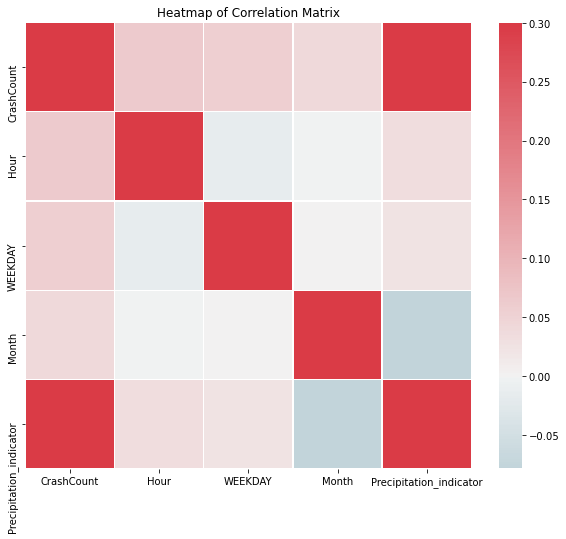

In [165]:
# Heatmap of features
corr = df.corr()
plt.figure(figsize = (10,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .82})
plt.title('Heatmap of Correlation Matrix')

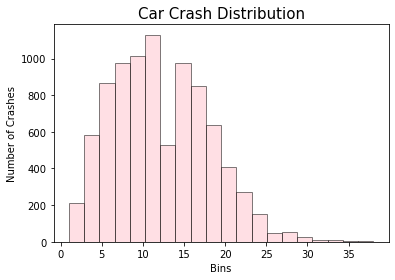

In [9]:
#histogram for Crashs
x = merged2['CrashCount']
num_bins = 20
plt.hist(x, num_bins, facecolor='pink', alpha=0.5, ec='black')

plt.xlabel('Bins')
plt.ylabel('Number of Crashes')
plt.title('Car Crash Distribution', fontsize = 15)

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7fc180de9b80>,
 'caps': [<matplotlib.lines.Line2D at 0x7fc180df6280>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fc180de9820>],
 'medians': [<matplotlib.lines.Line2D at 0x7fc180df6940>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fc180df6ca0>],
 'means': []}

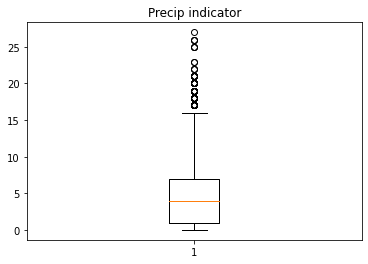

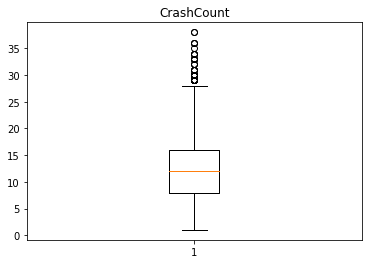

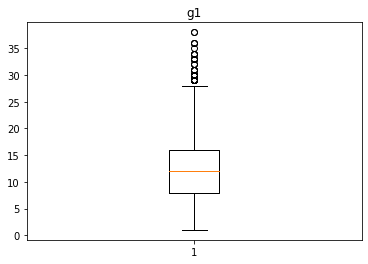

In [10]:
#crash count box and whiskers
fig1, ax1 = plt.subplots()
ax1.set_title('Precip indicator')
ax1.boxplot(merged2['Precipitation_indicator'])

#crash count box and whiskers
fig1, ax1 = plt.subplots()
ax1.set_title('CrashCount')
ax1.boxplot(merged2['CrashCount'])

#crash count box and whiskers
fig1, ax1 = plt.subplots()
ax1.set_title('g1')
ax1.boxplot(merged2['CrashCount'])

In [11]:
#Number of Crashes per weekday

time_group = merged2.groupby(['Month', 'WEEKDAY', 'T_12to5AM'])['CrashCount'].sum()
print(time_group)


Month  WEEKDAY  T_12to5AM
1      0        0             795
                1             262
       1        0             836
                1             486
       2        0             917
                             ... 
12     4        0             857
                1             836
       5        0            1021
       6        0             444
                1             386
Name: CrashCount, Length: 156, dtype: int64


In [12]:
#number of crashes per time period

month_group = merged2.groupby(merged2['Month'])['CrashCount'].sum()
month_group
    


Month
1     7957
2     7311
3     9066
4     9115
5     9774
6     9458
7     9133
8     8793
9     9214
10    9573
11    8598
12    8430
Name: CrashCount, dtype: int64

In [13]:
time_group = merged2.groupby(merged2['Hour'])['CrashCount'].sum()
time_group

Hour
0     6222
1     6338
2     6743
3     5681
4     4701
5     3627
6     2733
7     2320
8     2293
9     2446
10    2276
11    2250
12    2504
13    3694
14    5030
15    5469
16    5259
17    5336
18    5651
19    5020
20    4069
21    4950
22    5723
23    6087
Name: CrashCount, dtype: int64

In [127]:
percip_group = merged2.groupby(['Precipitation_indicator'])['CrashCount'].sum()
percip_group

Precipitation_indicator
0     20534
1      5882
2      7735
3      8600
4     10036
5      8921
6      7347
7      6742
8      5783
9      4682
10     4469
11     3426
12     2689
13     2497
14     2144
15     1490
16      971
17      787
18      383
19      416
20      322
21      222
22       86
23       55
25       84
26       85
27       34
Name: CrashCount, dtype: int64

In [125]:
#export dataset to csv
merged2.to_csv('/Users/samuelclark/Documents/UMBC Data Science /Introduction to Data Science/Final Project/Data/merged.csv',
             index= False)